In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB

import re
import string
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [39]:
data=pd.read_csv('Reviews_sample_balanced.csv')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,245686,B004OAZ36I,A2YBCX65HGP69W,Heart1970,0,0,5,1331510400,Great price and coffee,What a great deal to have the K cups delivered...,positive
1,54067,B001EPQ9IC,A17VK55PM9K828,Dolores Randall,0,0,2,1261180800,Disappointing for me,Perhaps there is too much yeast extract in it;...,negative
2,213681,B0039LVLS2,A3RYMO6S22FMM5,"Vanessa Strange ""porph princess""",2,3,1,1302566400,Too Salty for Me!,"I'm really disappointed in these, unless for s...",negative
3,353041,B000FEXUVW,AGS17Q9CLK3CK,DocD,2,4,1,1334620800,Good nut bad store,"Be very careful of the store ""TheNewMall"" who ...",negative
4,161814,B001CGTN3G,AYGJ96W5KQMUJ,SJP,7,10,1,1320969600,"Good for others maybe, not for me",I put two tablespoons (two-thirds of what the ...,negative


In [40]:
data.info()
data['Sentiment'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      10000 non-null  int64 
 1   ProductId               10000 non-null  object
 2   UserId                  10000 non-null  object
 3   ProfileName             10000 non-null  object
 4   HelpfulnessNumerator    10000 non-null  int64 
 5   HelpfulnessDenominator  10000 non-null  int64 
 6   Score                   10000 non-null  int64 
 7   Time                    10000 non-null  int64 
 8   Summary                 10000 non-null  object
 9   Text                    10000 non-null  object
 10  Sentiment               10000 non-null  object
dtypes: int64(5), object(6)
memory usage: 859.5+ KB


Sentiment
positive    5000
negative    5000
Name: count, dtype: int64

In [41]:
data["TextFull"] = data["Summary"].fillna("") + " " + data["Text"].fillna("")


In [42]:
data["Sentiment"] = data["Sentiment"].apply(lambda x: 1 if x == 'positive' else 0)


In [43]:
import ssl
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/tamara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tamara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [44]:
data['TextFull'].iloc[1]

"Disappointing for me Perhaps there is too much yeast extract in it; I don't know if it is common to add yeast extract to olive spread, but I didn't care for this at all."

In [45]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

data["cleaned_review"] = data["TextFull"].apply(clean_text)

In [46]:
final_df = data[["cleaned_review", "Sentiment"]]
final_df.head()


,cleaned_review,Sentiment
0,great price coffee great deal k cup delivered ...,1
1,disappointing perhaps much yeast extract know ...,0
2,salty really disappointed unless reason got ba...,0
3,good nut bad store careful store thenewmall ch...,0
4,good others maybe put two tablespoon two third...,0


In [47]:
final_df['cleaned_review'].iloc[1]

'disappointing perhaps much yeast extract know common add yeast extract olive spread care'

In [50]:
final_df['Sentiment'].value_counts()


Sentiment
1    5000
0    5000
Name: count, dtype: int64

In [60]:
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2), min_df=5)
X = tfidf.fit_transform(final_df["cleaned_review"])
y = final_df["Sentiment"]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Naive Bayes accuracy: 88.85%

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1000
           1       0.88      0.91      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



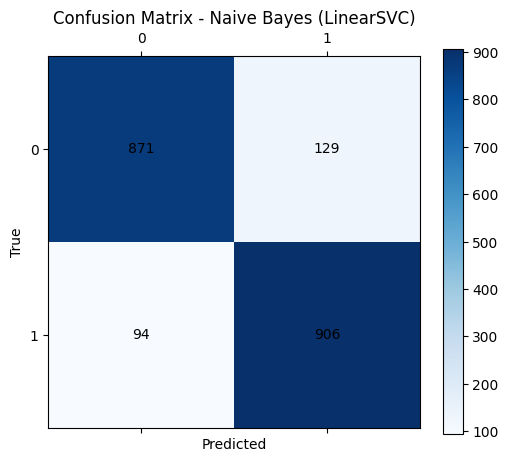

In [65]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)  
predictions = nb_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Naive Bayes accuracy:", "{:04.2f}".format(accuracy * 100) + "%\n")

print("Classification Report:\n")
print(classification_report(y_test, predictions))
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(6,5))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Naive Bayes (LinearSVC)')
fig.colorbar(cax)

ax.set_xlabel("Predicted")
ax.set_ylabel("True")

for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, str(val), ha='center', va='center')

plt.show()